# Loading Packages

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from hashlib import md5
from IPython.display import display, Markdown, Latex, Code
from scipy.special import logsumexp
import os.path
import pystan
from hashlib import md5

# Preprocessing data

In [28]:
def process_data(data_path, mean_sea_level_path, debug=False):
    print(f"Processing data from files: {data_path}, {mean_sea_level_path}")
    
    data = pd.read_csv(data_path)
    mean_sea_level_data = pd.read_csv(mean_sea_level_path)
    year_means = []
    
    for year in range(1971, 2020):
        year_means.append(np.mean(data.loc[data['Year'] == year]['Water level (mm)'].values))

    # Normalize data
    normalized_data_path = f"{data_path}_n.csv"
    if os.path.isfile(normalized_data_path):
        n_data = pd.read_csv(normalized_data_path)
        n_data['date'] = pd.to_datetime(n_data['date'])
        n_data.set_index('date', inplace=True)
        print(f"Read normalized data from {normalized_data_path}")
    
    else:
        n_data = data.copy()
        print(f"Normalizing {data_path}")
        for i, row in n_data.iterrows():
            if i % 1000 == 0:
                print('\r ready: %.2f%%' % (i / len(n_data) * 100), end=" ")
            n_data.iat[i, 5] = row['Water level (mm)'] - mean_sea_level_data.loc[mean_sea_level_data['Year'] == row['Year']].values[0][1]
    
        # Add date index
        import datetime
        def row_to_timestamp(row):
            year = row['Year']
            month = row['m']
            day = row['d']
            hours = datetime.datetime.strptime(row['Time'], "%H:%M").hour
            date = pd.to_datetime(datetime.datetime(year, month, day, hours))
            return date
    
        n_data['date'] = n_data.apply(row_to_timestamp, axis=1)
        n_data.set_index('date', inplace=True)
        n_data['year'] = n_data.index.year + (n_data.index.dayofyear - 1) / 365 + (n_data.index.hour) / (365 * 24)
    
        n_data = n_data.rename(columns={'Water level (mm)': 'water_level'})
    
        n_data.to_csv(normalized_data_path)
        print(f"\nWrote output to {normalized_data_path}")
    
    monthly_means = n_data.resample('M').mean().dropna()
    yearly_means = n_data.resample('Y').mean().dropna()
    
    nans = np.argwhere(np.isnan(monthly_means['water_level']))
    
    return yearly_means, monthly_means


In [49]:
kemi_data_path = r"/home/prakhar/projects/Finnish_Water_Level/data/Kemi.csv"
kemi_mean_sea_level_path = r"/home/prakhar/projects/Finnish_Water_Level/data/kemi_mw_n2000.csv"

yearly_means, monthly_means = process_data(kemi_data_path, kemi_mean_sea_level_path)

Processing data from files: /home/prakhar/projects/Finnish_Water_Level/data/Kemi.csv, /home/prakhar/projects/Finnish_Water_Level/data/kemi_mw_n2000.csv
Read normalized data from /home/prakhar/projects/Finnish_Water_Level/data/Kemi.csv_n.csv


In [87]:
k=1

x = list(range(1971, 2020)) * k
y = np.array(yearly_means['water_level'])

g = sum(list(map(lambda x: [x]*49, [i for i in range(1, k + 1)])), [])

data = {
    'N': k*len(yearly_means),
    'K': k,
    'x': x,
    'y': y,
    'g': g
}
print(data)

{'N': 49, 'K': 1, 'x': [1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 'y': array([-370.40845237, -426.35098805, -298.13409696, -324.10933631,
       -278.34430055, -427.80666125, -396.55801234, -410.77579909,
       -355.61038813, -431.52185792, -277.49179565, -250.20674104,
       -167.05856164, -323.96344435, -339.33721461, -273.20125571,
       -321.63618721, -246.02386703, -176.23709168, -111.54075342,
       -238.67283105, -169.10598816, -230.73424658, -210.50730594,
       -156.46518265, -371.57365665, -236.36598174, -167.10148402,
       -179.46255708, -250.8989071 , -219.88526087, -243.02956621,
       -221.92591324,  483.26684882, -117.24386345, -191.14600457,
        -25.74828767, -105.24146175, -202.34041096, -275.11712329,
      

In [74]:
def compile_model(model_code, model_name=None):
    """This will automatically cache models - great if you're just running a
    script on the command line.
    See http://pystan.readthedocs.io/en/latest/avoiding_recompilation.html"""

    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [103]:
separate_stan_model = """
data {
  int<lower=0> N; // number of data points
  int<lower=1> K; // number of groups
  vector[N] y;
  vector[N] x;  // years
  int<lower=1,upper=K> g[N];
}
parameters {
  vector[K] alpha;
  vector[K] beta;
  vector<lower=0>[K] sigma;
}
model {
  beta ~ normal(3.3, 10^2);
  y ~ normal(alpha[g] + beta[g].*(x-1971), sigma[g]);
}
generated quantities {
 vector[N] log_lik;
 vector[N] y_rep;
 for (i in 1:N) {
   log_lik[i] = normal_lpdf(y[i] | alpha[g[i]] + beta[g[i]].* (x[i]-1971), sigma[g[i]]);
   y_rep[i] = normal_rng(alpha[g[i]] + beta[g[i]].* (x[i]-1971), sigma[g[i]]);
 }
}
"""
sm_separate = compile_model(separate_stan_model, model_name="separate")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f1fcc20ec2f4f42583b829214457b8e NOW.


In [97]:
hierarchical_stan_model = """
data {
  int<lower=0> N; // number of data points
  int<lower=1> K; // number of groups
  vector[N] y;
  vector[N] x;  // years
  int<lower=1,upper=K> g[N];
}
parameters {
  vector[K] alpha;
  vector[K] beta;
  real beta0;
  real<lower=0> sigma0;
  real<lower=0> sigma;
}
model {
  beta0 ~ normal(3.3, 10^2);
  sigma0 ~ normal(0, 10);
  beta ~ normal(beta0, sigma0);
  y ~ normal(alpha[g] + beta[g].*(x-1971), sigma);
}
generated quantities {
 vector[N] log_lik;
 vector[N] y_rep;
 for (i in 1:N) {
   y_rep[i] = normal_rng(alpha[g[i]] + beta[g[i]] .* (x[i]-1971), sigma);
   log_lik[i] = normal_lpdf(y[i] | alpha[g[i]] + beta[g[i]] .* (x[i]-1971), sigma);
 }
}
"""
sm_hierarchical = compile_model(hierarchical_stan_model, model_name="hierarchical")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_245f3f3f6df5b3360ad1d7db4c0503f6 NOW.


In [104]:
fit = sm_separate.sampling(data)

In [98]:
fit_h = sm_hierarchical.sampling(data)

In [100]:
def fit_summary(fit1, fit2):
    s1 = fit1.summary()
    s2 = fit2.summary()
    summary1 = pd.DataFrame(s1['summary'][:18,-2:], columns=['n_eff', 'Rhat'], index=s1['summary_rownames'][:18])
    summary1 = summary1.rename(index=str, columns={"n_eff": "seperate: n_eff", "Rhat": "seperate: Rhat"})
    summary2 = pd.DataFrame(s2['summary'][:15,-2:], columns=['n_eff', 'Rhat'], index=s2['summary_rownames'][:15])
    summary2 = summary2.rename(index=str, columns={"n_eff": "hierarchial: n_eff", "Rhat": "hierarchial: Rhat"})
    summary3 = summary1.join(summary2, how='outer')
    return summary3

In [105]:
summary = fit_summary(fit, fit_h)
display(summary)

,seperate: n_eff,seperate: Rhat,hierarchial: n_eff,hierarchial: Rhat
alpha[1],1541.006552,1.001576,1575.274391,1.003799
beta0,NaN,NaN,1134.846846,1.003001
beta[1],1519.084886,1.002022,1663.887346,1.003765
log_lik[10],1803.066374,1.001121,1824.309555,1.002676
log_lik[11],1845.052182,1.002452,NaN,NaN
log_lik[12],1908.298648,1.002671,NaN,NaN
log_lik[13],2048.113659,1.001194,NaN,NaN
log_lik[14],1864.467352,1.000189,NaN,NaN
log_lik[15],1967.632148,1.000009,NaN,NaN
log_lik[1],1535.542291,1.002393,1577.087576,1.000886


In [106]:
def plot_results(ax, x, y, k, data, title):
    x = np.array(x).reshape((-1,1))
    alpha = np.mean(y['alpha'][:,k])
    beta = np.mean(y['beta'][:,k])
    mu = y['alpha'][:,k] + x * y['beta'][:,k]
    ax[k//2,k%2].plot(x+1971, np.mean(mu, axis=1), linewidth=1, color='r', label=fr"$\alpha$: {alpha:.2f}  $\beta$: {beta:.2f}")
    ax[k//2,k%2].plot(x+1971, np.percentile(mu, 5, axis=1), linestyle="--", color='orange')
    ax[k//2,k%2].plot(x+1971, np.percentile(mu, 95, axis=1), linestyle="--", color='orange')
    ax[k//2,k%2].scatter(x+1971, data['water_level'], label=None)
    ax[k//2,k%2].set_title(title)
    ax[k//2,k%2].legend(fontsize=20)

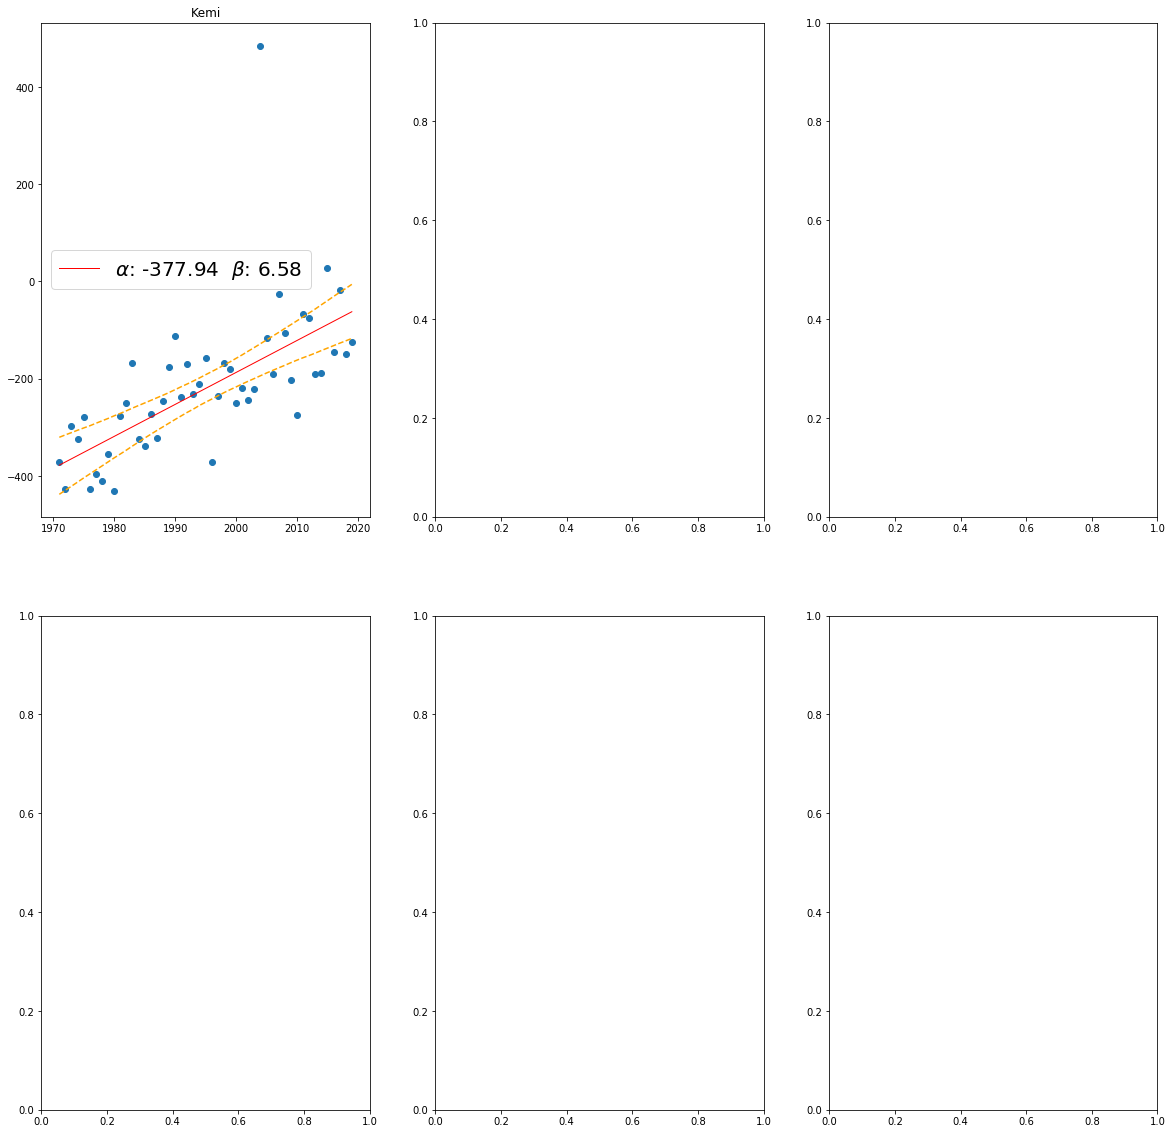

In [96]:
out = fit.extract()
fig, ax = plt.subplots(2,3, figsize=(20,20))
plot_results(ax, range(0, 49), out, 0, yearly_means, 'Kemi')